<a href="https://colab.research.google.com/github/aimiliavaitsi/PubMedScrapping/blob/main/PubMed_Scrapping_Bioplastics_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching articles for year 2010...
Fetching articles for year 2011...
Fetching articles for year 2012...
Fetching articles for year 2013...
Fetching articles for year 2014...
Fetching articles for year 2015...
Fetching articles for year 2016...
Fetching articles for year 2017...
Fetching articles for year 2018...
Fetching articles for year 2019...
Fetching articles for year 2020...
Fetching articles for year 2021...
Fetching articles for year 2022...
Fetching articles for year 2023...
Fetching articles for year 2024...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

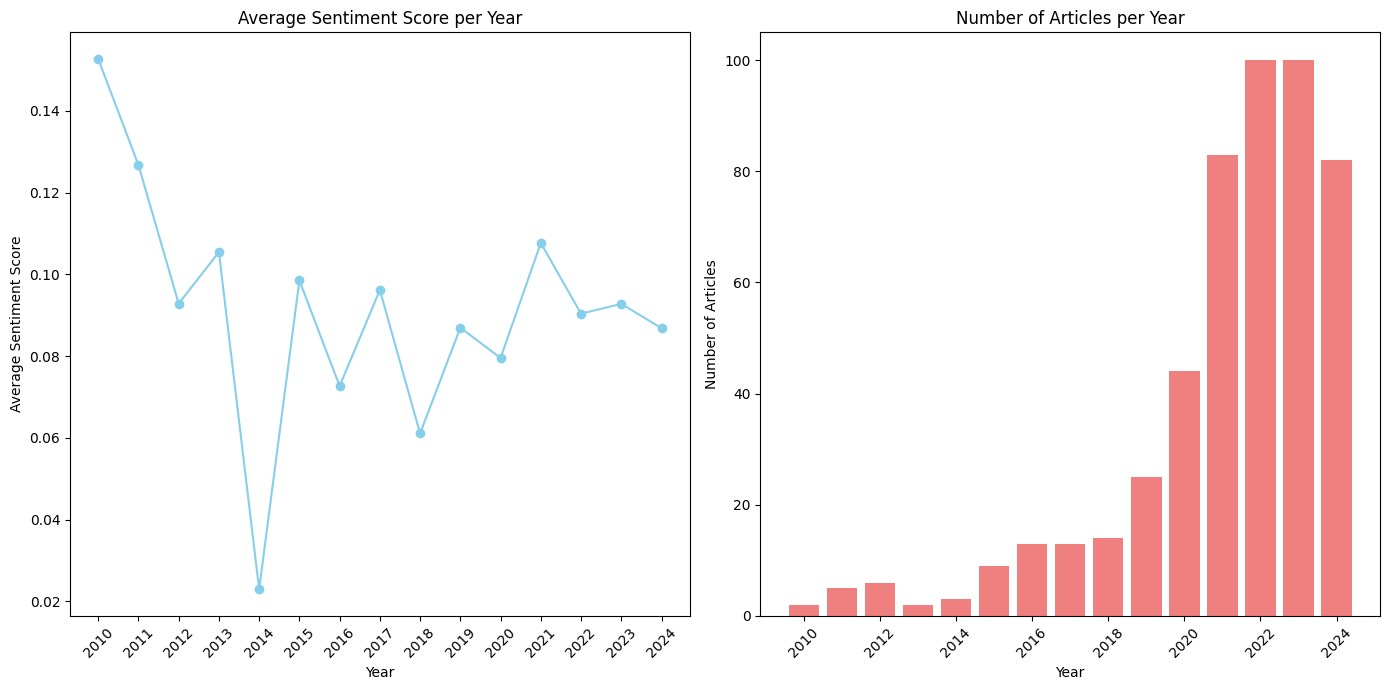

In [ ]:
# Install required packages
!pip install biopython textblob matplotlib openpyxl

import pandas as pd
from Bio import Entrez
from google.colab import files
from textblob import TextBlob
import matplotlib.pyplot as plt
import datetime
import math

# Set the email address to avoid any potential issues with Entrez
Entrez.email = 'your.email@example.com'

# Function to perform sentiment analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns sentiment polarity score

# Function to count keyword occurrences
def count_keywords(text, keywords):
    text_lower = text.lower()
    count = sum(text_lower.count(keyword) for keyword in keywords)
    return count

# Function to search PubMed and fetch articles
def fetch_articles(year, max_results=500):
    date_range = f'("{year}/01/01"[Date - Create] : "{year}/12/31"[Date - Create])'
    full_query = f'({" OR ".join(topics)}) AND {date_range}'

    # Initial search to find out the number of records
    handle = Entrez.esearch(db='pubmed', retmax=1, term=full_query)
    record = Entrez.read(handle)
    total_count = int(record['Count'])

    articles = []
    if total_count > 0:
        # Calculate the number of batches needed
        batches = math.ceil(total_count / 500)

        for batch in range(batches):
            retstart = batch * 500
            handle = Entrez.esearch(db='pubmed', retmax=500, retstart=retstart, term=full_query)
            record = Entrez.read(handle)
            id_list = record['IdList']

            # Fetch detailed information for each record
            for pmid in id_list:
                handle = Entrez.efetch(db='pubmed', id=pmid, retmode='xml')
                records = Entrez.read(handle)

                # Process each PubMed article in the response
                for record in records['PubmedArticle']:
                    title = record['MedlineCitation']['Article']['ArticleTitle']
                    abstract = ' '.join(record['MedlineCitation']['Article']['Abstract']['AbstractText']) if 'Abstract' in record['MedlineCitation']['Article'] and 'AbstractText' in record['MedlineCitation']['Article']['Abstract'] else ''
                    # Extract the publication year from the publication date
                    pub_date = record['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']
                    year = pub_date.get('Year', 'N/A')

                    # Check keyword occurrence
                    if count_keywords(title, keyword_list) >= 3 or count_keywords(abstract, keyword_list) >= 3:
                        sentiment_score = analyze_sentiment(abstract)
                        articles.append({
                            'Title': title,
                            'Abstract': abstract,
                            'Year': year,
                            'Sentiment': sentiment_score
                        })

                    # Break if we have enough articles for the year
                    if len(articles) >= max_results:
                        break
                # Break the outer loop if we have enough articles
                if len(articles) >= max_results:
                    break
    return articles

# Define topics and date range
topics = [
    'bioplastics[Title/Abstract]',
    'bioplastic[Title/Abstract]',
    'natural plastic[Title/Abstract]',
    'biodegradable plastic[Title/Abstract]',
    'sustainable plastic[Title/Abstract]'
]

# Keyword list for counting occurrences
keyword_list = ['bioplastics', 'bioplastic', 'natural plastic', 'biodegradable plastic', 'sustainable plastic']

# Prepare DataFrame to store the results
df = pd.DataFrame(columns=['Title', 'Abstract', 'Year', 'Sentiment'])

# Dictionary to keep track of the count of articles per year
article_counts = {}

# Loop over the years from 2010 to the current year
current_year = datetime.datetime.now().year
for year in range(2010, current_year + 1):
    print(f"Fetching articles for year {year}...")
    articles = fetch_articles(year, max_results=100)
    # Append articles to DataFrame
    df = pd.concat([df, pd.DataFrame(articles)], ignore_index=True)

    # Update the article counts
    article_counts[year] = len(articles)

# Save DataFrame to an Excel file
file_name = 'PubMed_results.xlsx'
df.to_excel(file_name, index=False)

# Download the file
files.download(file_name)

# Plot Sentiment Scores
plt.figure(figsize=(14, 7))

# Group by year and calculate mean sentiment score
sentiment_scores = df.groupby('Year')['Sentiment'].mean().sort_index()

# Plot line chart for sentiment scores
plt.subplot(1, 2, 1)
plt.plot(sentiment_scores.index, sentiment_scores.values, marker='o', linestyle='-', color='skyblue')
plt.title('Average Sentiment Score per Year')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)

# Plot Article Counts
plt.subplot(1, 2, 2)
years = list(article_counts.keys())
counts = list(article_counts.values())

plt.bar(years, counts, color='lightcoral')
plt.title('Number of Articles per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
